In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Cihaz seçimi (Varsa GPU, yoksa CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

class DoubleConv(nn.Module):
    """(Conv2d => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # --- Encoder (Aşağı İniş) ---
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        
        # --- Bottleneck (Dar Boğaz) ---
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # --- Decoder (Yukarı Çıkış) ---
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512) # Skip connection ile birleşince kanal sayısı artar
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # Çıkış katmanı
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder (Skip Connection kullanımı)
        x = self.up1(x5)
        # Boyut uyuşmazlığı olursa diye basit bir crop veya pad gerekebilir ama
        # padding=1 kullandığımız için 2'nin katı boyutlarda sorun çıkmaz.
        # x4 ve x'i kanal boyutunda (dim=1) birleştiriyoruz
        x = torch.cat([x4, x], dim=1) 
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        logits = self.outc(x)
        return logits

class OxfordPetDataset(datasets.OxfordIIITPet):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        
        # Görüntü ve maske boyutlarını sabitleme (128x128 hızlı eğitim için)
        img = img.resize((128, 128))
        target = target.resize((128, 128))

        # Dönüşümler
        transform_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        img_tensor = transform_img(img)
        
        # Maske işlemleri:
        # Oxford Pet maskeleri 1, 2, 3 değerlerine sahiptir. 
        # CrossEntropyLoss için bunları 0, 1, 2'ye çekiyoruz.
        target_np = np.array(target) - 1 
        target_tensor = torch.tensor(target_np, dtype=torch.long) # LongTensor gerekli

        return img_tensor, target_tensor

# Veri setini indir ve yükle
print("Veri seti indiriliyor (ilk seferde biraz sürebilir)...")
train_dataset = OxfordPetDataset(root='./data', split='trainval', target_types='segmentation', download=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

print(f"Eğitim veri sayısı: {len(train_dataset)}")



Kullanılan cihaz: cuda
Veri seti indiriliyor (ilk seferde biraz sürebilir)...


100%|██████████| 792M/792M [00:28<00:00, 27.9MB/s] 
100%|██████████| 19.2M/19.2M [00:01<00:00, 13.4MB/s]


Eğitim veri sayısı: 3680


In [5]:
def calculate_metrics(pred_tensor, target_tensor, n_classes):
    """
    Batch için ortalama IoU (mIoU) ve Pixel Accuracy hesaplar.
    """
    # Tahminleri sınıf indekslerine çevir (Argmax)
    # Çıktı boyutu: [Batch, H, W]
    pred_inds = torch.argmax(pred_tensor, dim=1).view(-1)
    target_inds = target_tensor.view(-1)
    
    # Pixel Accuracy (Basit Piksel Doğruluğu)
    # Doğru tahmin edilen piksel sayısı / Toplam piksel sayısı
    correct_pixels = (pred_inds == target_inds).sum().item()
    total_pixels = target_inds.size(0)
    pixel_acc = correct_pixels / total_pixels

    # IoU Hesaplama (Her sınıf için ayrı ayrı)
    ious = []
    for cls in range(n_classes):
        pred_mask = (pred_inds == cls)
        target_mask = (target_inds == cls)
        
        intersection = (pred_mask & target_mask).sum().item() # Kesişim
        union = (pred_mask | target_mask).sum().item()        # Birleşim
        
        if union == 0:
            # Bu sınıf bu batch'te hiç yoksa hesaplamaya katma
            ious.append(float('nan')) 
        else:
            ious.append(intersection / union)
            
    # nanmean: NaN olanları yoksayarak ortalama alır
    mean_iou = np.nanmean(ious)
    
    return mean_iou, pixel_acc

In [6]:
#Oxford veri seti 3 sınıfa sahiptir:
#Evcil Hayvan
#Arka Plan
#Kenarlık (Border)

# Modeli ve Optimizer'ı tekrar başlatalım (sıfırdan eğitim için)
model = UNet(n_channels=3, n_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10  # Epoch sayısını biraz artırdık

print("Eğitim ve Metrik Takibi Başlıyor...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    # Progress bar yerine basit sayaç
    total_batches = len(train_loader)
    
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # 1. Forward Pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # 2. Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 3. Metrikleri Hesapla (Gradyan takibine gerek yok)
        with torch.no_grad():
            mean_iou, pixel_acc = calculate_metrics(outputs, masks, n_classes=3)
        
        # İstatistikleri topla
        running_loss += loss.item()
        running_iou += mean_iou
        running_acc += pixel_acc

    # Epoch sonu ortalamaları
    epoch_loss = running_loss / total_batches
    epoch_iou = running_iou / total_batches
    epoch_acc = running_acc / total_batches
    
    print(f"Epoch [{epoch+1}/{num_epochs}] -> "
          f"Loss: {epoch_loss:.4f} | "
          f"mIoU: {epoch_iou:.4f} | "
          f"Pixel Acc: {epoch_acc:.4f}")

print("Eğitim Tamamlandı.")

Eğitim ve Metrik Takibi Başlıyor...
Epoch [1/10] -> Loss: 0.6375 | mIoU: 0.4541 | Pixel Acc: 0.7351
Epoch [2/10] -> Loss: 0.5210 | mIoU: 0.5317 | Pixel Acc: 0.7932
Epoch [3/10] -> Loss: 0.4563 | mIoU: 0.5851 | Pixel Acc: 0.8216
Epoch [4/10] -> Loss: 0.4109 | mIoU: 0.6190 | Pixel Acc: 0.8405
Epoch [5/10] -> Loss: 0.3786 | mIoU: 0.6418 | Pixel Acc: 0.8530
Epoch [6/10] -> Loss: 0.3521 | mIoU: 0.6616 | Pixel Acc: 0.8638
Epoch [7/10] -> Loss: 0.3351 | mIoU: 0.6744 | Pixel Acc: 0.8714
Epoch [8/10] -> Loss: 0.3187 | mIoU: 0.6856 | Pixel Acc: 0.8774
Epoch [9/10] -> Loss: 0.3108 | mIoU: 0.6921 | Pixel Acc: 0.8807
Epoch [10/10] -> Loss: 0.2910 | mIoU: 0.7070 | Pixel Acc: 0.8891
Eğitim Tamamlandı.


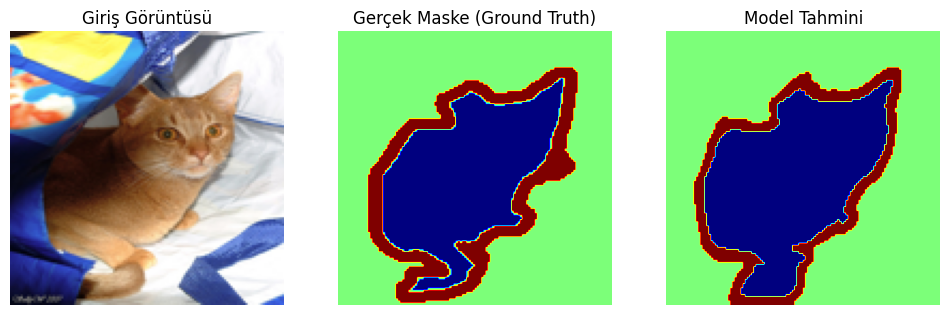

In [13]:
model.eval()
# Veri setinden rastgele bir örnek al
img, mask = train_dataset[0] 
img_input = img.unsqueeze(0).to(device) # Batch boyutu ekle

with torch.no_grad():
    output = model(img_input)
    # En yüksek olasılıklı sınıfı seç (Argmax)
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu()

# Görselleştirme
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Orijinal Görüntü (Normalize edildiği için geri alıyoruz)
img_show = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
ax[0].imshow(img_show)
ax[0].set_title("Giriş Görüntüsü")
ax[0].axis('off')

# Gerçek Maske
ax[1].imshow(mask, cmap='jet')
ax[1].set_title("Gerçek Maske (Ground Truth)")
ax[1].axis('off')

# Tahmin
ax[2].imshow(prediction, cmap='jet')
ax[2].set_title("Model Tahmini")
ax[2].axis('off')

plt.show()